#  Predicting gridlocked traffic

Scenario: You work as a data scientist for a taxi app that operates in Ecuador, among other places. The company is represented there mainly in the capital Quito. In order to make the app more user friendly, the company wants to model how long passengers are likely to be in traffic more precisely. To do this, your company has tracked how long each vehicle is standing still for each journey. This is the variable to be calculated in advance.

If passengers know in advance how long they will be in traffic, they can better prepare for potentially long journeys and have a more positive journey experience. Moreover, since the costs are calculated mainly by distance and less by duration of the journey, these trips are not as lucrative as trips that the taxi might otherwise be able to make.

The following background information on Quito could be helpful in the task:

You can get an overview of the city here.
Since since this project is particularly about traffic in the city and suburbs including the airport, you can assume that only the data within the following coordinates is relevant for the predictions:
Maximum and minimum latitude: [-0.4,0.05]
Maximum and minimum latitude: [-78.6,-78.3]
In Ecuador the rainy season goes from October to May and the dry season from June to September.
The speed limit is 50 km/h in the city and 70 km/h towards the airport.

***
The following have done in this exercise:
* Imported and cleaned the data
* Carried out feature engineering
* Fitted the model to the data
* Combined the individual steps into to a data pipeline
***

### Preparation

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('data_train.csv')

In [3]:
df.head()

,id,vendor_id,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_estimated,distance_m,wait_sec
0,0,Quito,25-08-16 12:40,-78.411326,-0.309814,-78.455283,-0.287551,N,678,7363.299869,38
1,1,Quito,17-12-16 5:29,-78.512510,-0.221165,-78.478725,-0.196938,N,750,6450.734909,210
2,2,Quito,16-03-17 5:36,-78.467560,-0.163823,-78.483523,-0.094844,N,1274,9445.014567,666
3,3,Quito,20-10-16 9:25,-78.472038,-0.139989,-78.494747,-0.169194,N,615,5772.514970,312
4,4,Quito,01-12-16 12:58,-78.493910,-0.176009,-78.504876,-0.180504,N,308,1719.218262,70


Which data types are there?
Are there any missing values?
Are there any duplicate entries?
How are the values distributed?
Which features should you look at more closely in visualizations?
Where are there outliers?


In [4]:
df.dtypes

id                      int64
vendor_id              object
pickup_datetime        object
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_estimated          int64
distance_m            float64
wait_sec                int64
dtype: object

In [5]:
#check objects
print('df length: ', len(df))
print('vendor_id unique: ', df.vendor_id.unique())
print('vendor_id unique counts: ', df.vendor_id.value_counts())
print('store_and_fwd_flag unique: ', df.store_and_fwd_flag.unique())
print('store_and_fwd_flag unique counts: ', df.store_and_fwd_flag.value_counts())
#note: vendor id mostly consists of 'Quito'
#note: store_and_fwd_flag is all 'N', can be removed

df length:  15657
vendor_id unique:  ['Quito' 'Quito Cabify Lite' 'Quito Cabify Executive']
vendor_id unique counts:  Quito                     15469
Quito Cabify Lite           159
Quito Cabify Executive       29
Name: vendor_id, dtype: int64
store_and_fwd_flag unique:  ['N']
store_and_fwd_flag unique counts:  N    15657
Name: store_and_fwd_flag, dtype: int64


In [6]:
#check NaNs and duplicates
print('index_size', df.index.size)
print('is NaN', df.isna().sum())
print('duplicated', df.duplicated().sum())
#note: no NaNs, no duplicates, no cleaning required

index_size 15657
is NaN id                    0
vendor_id             0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_estimated        0
distance_m            0
wait_sec              0
dtype: int64
duplicated 0


,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_estimated,distance_m,wait_sec
count,15657.000000,15657.000000,15657.000000,15657.000000,15657.000000,1.565700e+04,15657.000000,15657.000000
mean,7828.000000,-78.491040,-0.186257,-78.491826,-0.188772,1.073200e+03,5447.242889,304.477295
std,4519.930918,0.031523,0.063181,0.032192,0.064844,2.409360e+04,4777.745393,284.184446
min,0.000000,-79.907673,-2.109441,-79.891648,-2.156118,-1.844000e+03,8.003643,0.000000
25%,3914.000000,-78.505258,-0.213994,-78.504300,-0.216839,3.130000e+02,2442.095418,108.000000
50%,7828.000000,-78.488799,-0.180563,-78.489255,-0.184772,5.140000e+02,4128.478934,222.000000
75%,11742.000000,-78.474127,-0.145438,-78.477369,-0.148315,8.280000e+02,6886.890834,404.000000
max,15656.000000,-78.173105,0.342586,-78.132796,0.349317,1.980260e+06,92322.757780,1929.000000


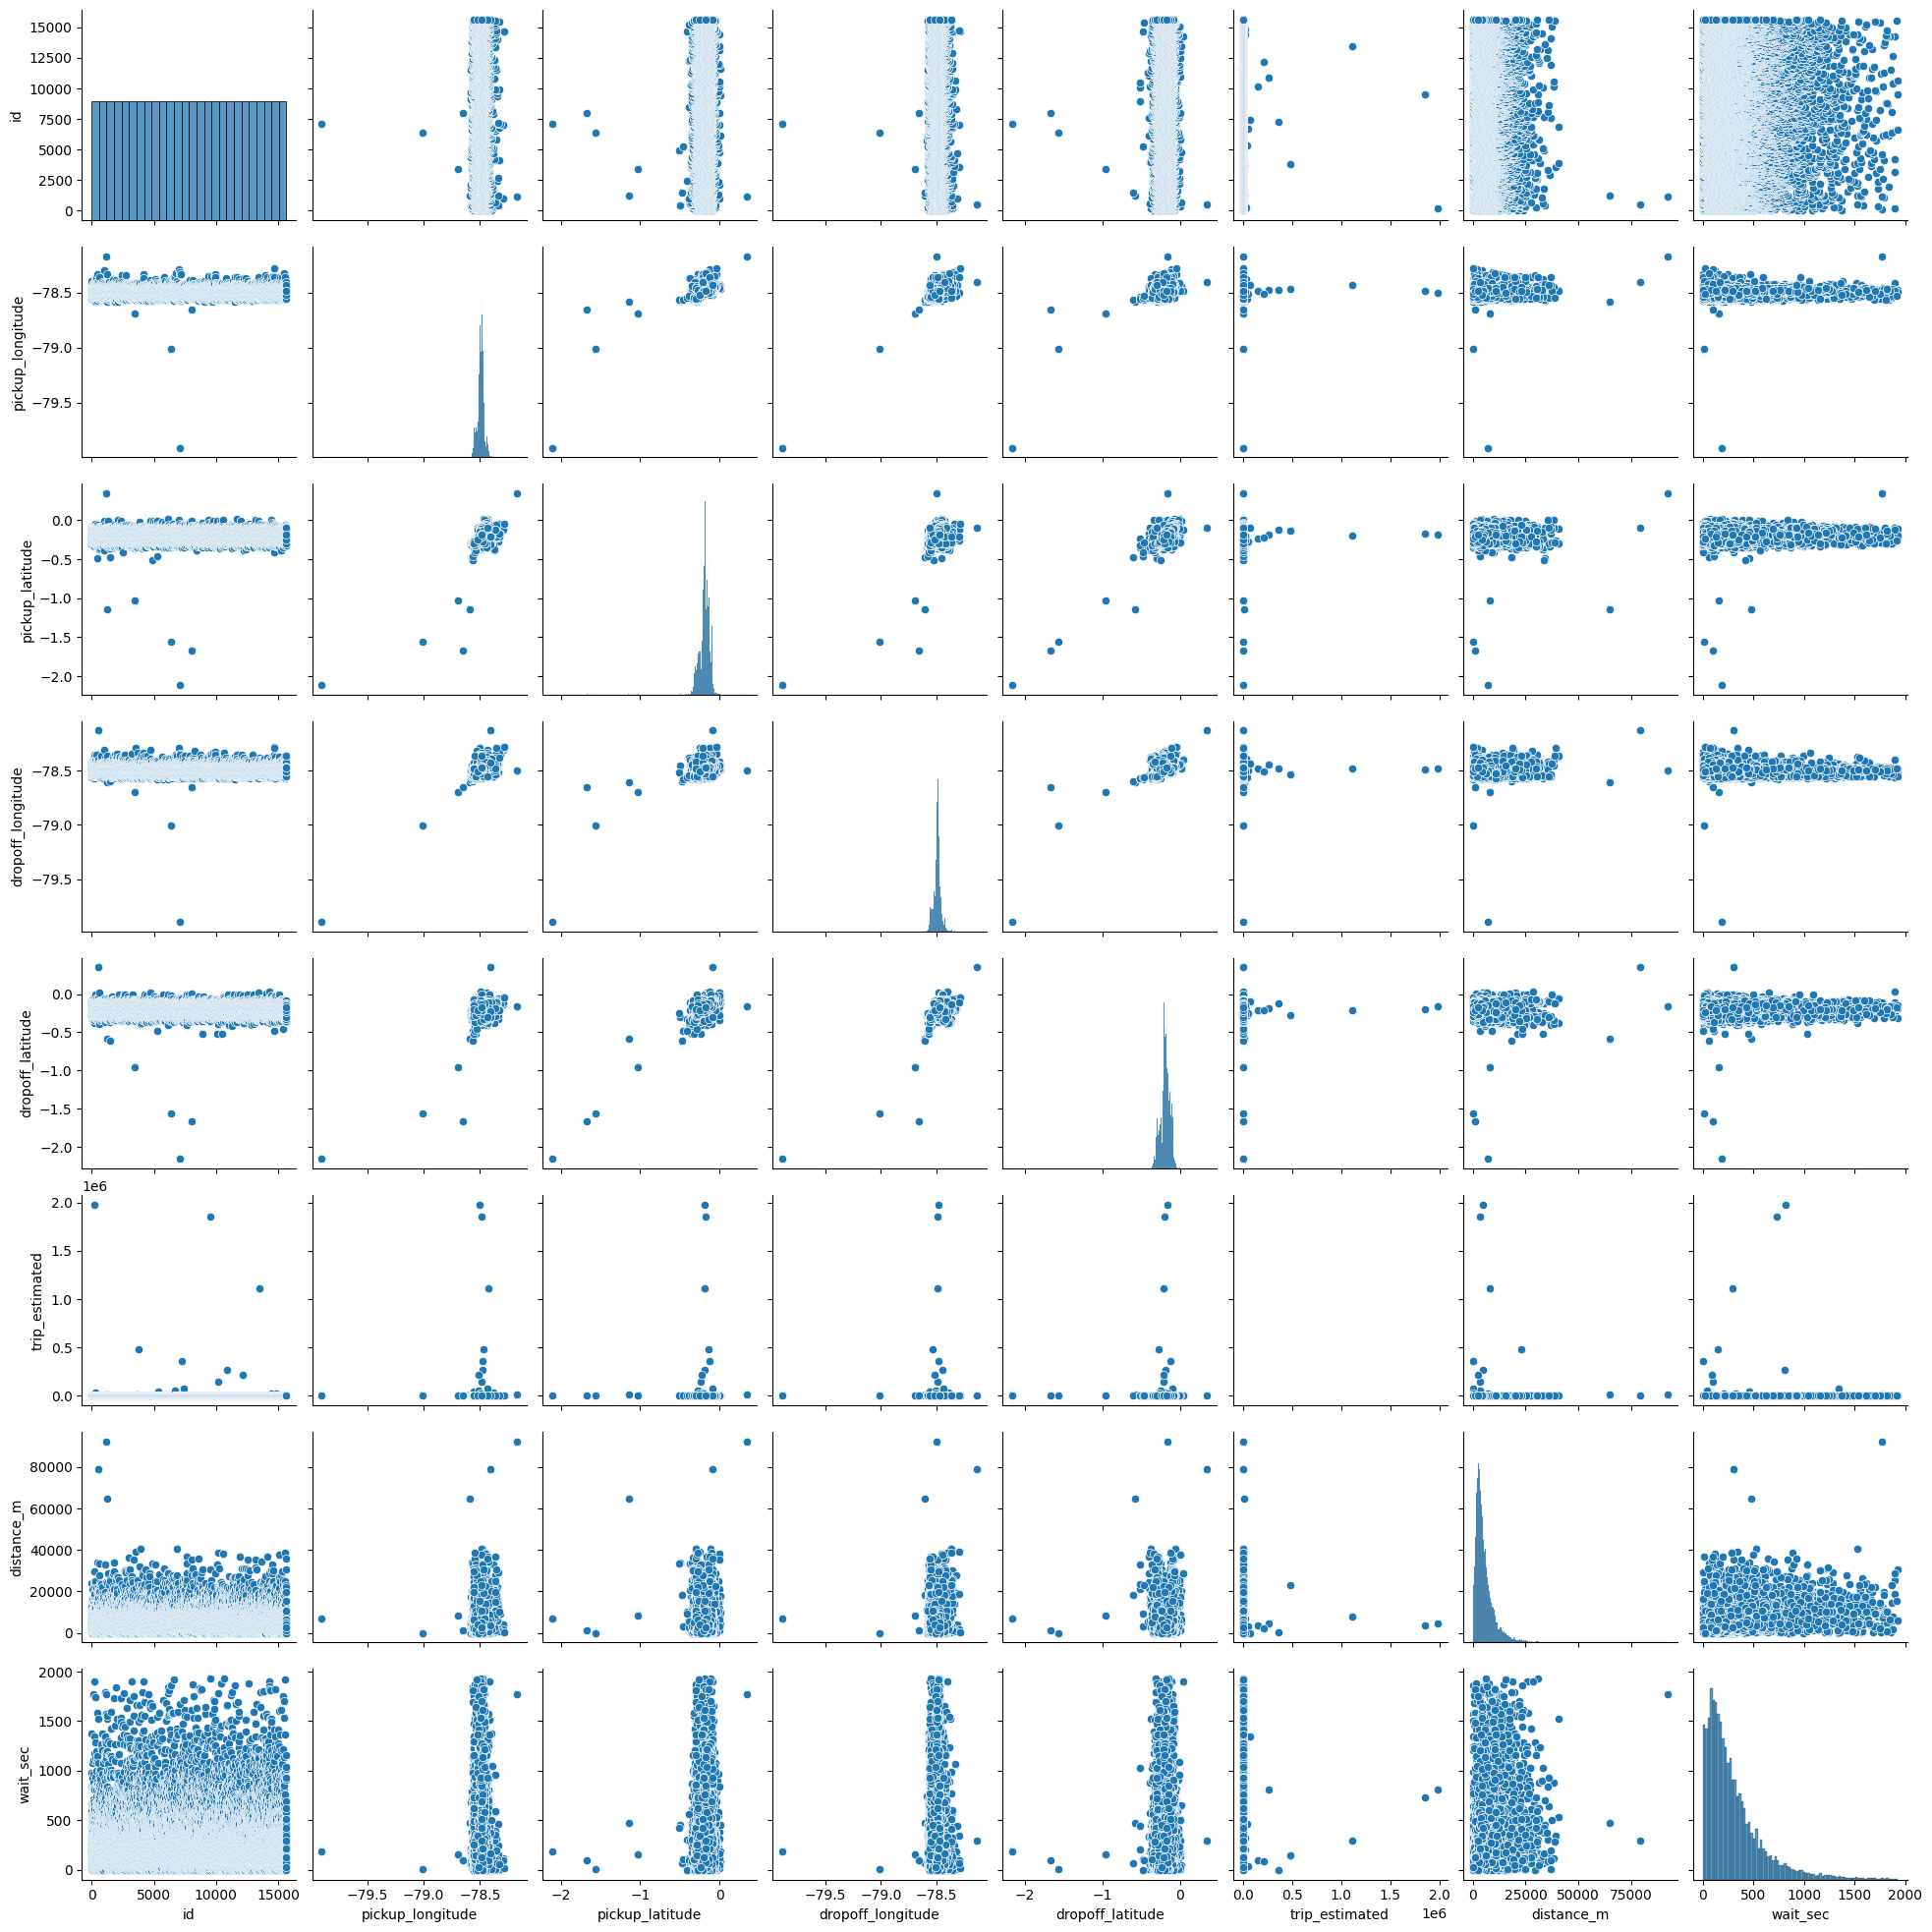

In [7]:
# check distribution of values in each feature
display(df.describe())
display(sns.pairplot(df))

(-0.4, 0.05)

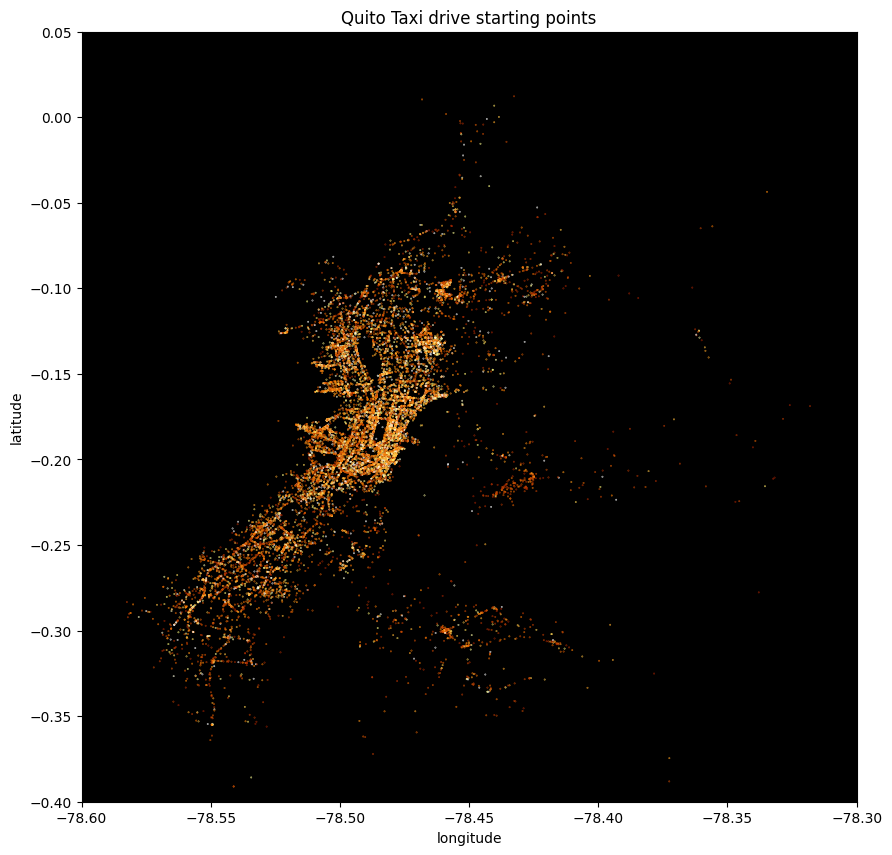

In [8]:
# import median absolute deviation (mad) from statsmodels and visualize data
from statsmodels.robust import mad

plt.figure(figsize=(10, 10))
plt.title('Quito Taxi drive starting points')
plt.xlabel('longitude')
plt.ylabel('latitude')

plt.scatter(df.pickup_longitude, df.pickup_latitude, c=df.wait_sec, s=0.1, cmap='afmhot')
plt.gca().set_facecolor('black')

median = df.loc[:, 'wait_sec'].median()
mad_value = mad(df.loc[:, 'wait_sec'])
plt.clim(median - 3 * mad_value, median + 3 * mad_value)
plt.xlim([-78.6, -78.3])
plt.ylim([-0.4, 0.05])

### Outlier detection

In [9]:
#import modules for outlier detection
from sklearn.linear_model import RANSACRegressor

Text(0.5, 0, 'trip_estimated')

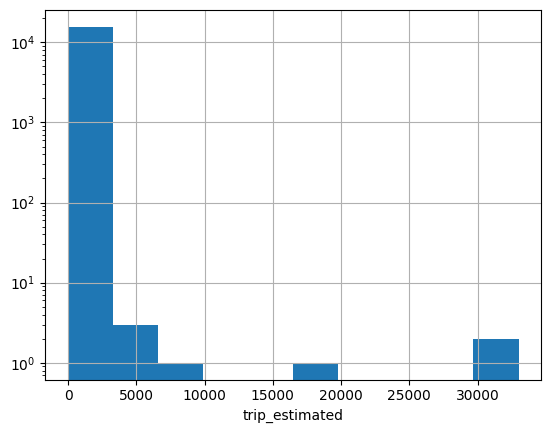

In [10]:
#histogram of trip_estimated showing outliers
df['trip_estimated'] = df['trip_estimated'] / 60 
df.trip_estimated.hist()
plt.gca().set_yscale('log')
plt.xlabel('trip_estimated')
#change scale to minutes

In [11]:
# find outliers in trip_estimated using RANSAC
d_distance = mad(df.loc[:, 'distance_m']) * 3

model_outlier = RANSACRegressor(residual_threshold=d_distance, random_state=0)
model_outlier.fit(X=df.loc[:, ['trip_estimated']], y=df.loc[:, 'distance_m'])

(~model_outlier.inlier_mask_).sum()

119

(0.0, 10000.0)

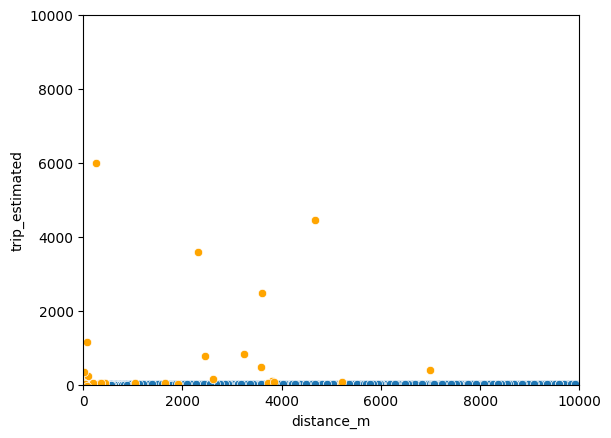

In [12]:
# visualize outliers with RANSAC
ax = sns.scatterplot(x=df.loc[model_outlier.inlier_mask_, 'distance_m'],
                     y=df.loc[model_outlier.inlier_mask_, 'trip_estimated'])

sns.scatterplot(x=df.loc[~model_outlier.inlier_mask_, 'distance_m'],
                y=df.loc[~model_outlier.inlier_mask_, 'trip_estimated'],
                color='orange', 
                ax=ax)

ax.set_ylim([0, 1e4])
ax.set_xlim([0, 1e4])

<Axes: >

<Axes: >

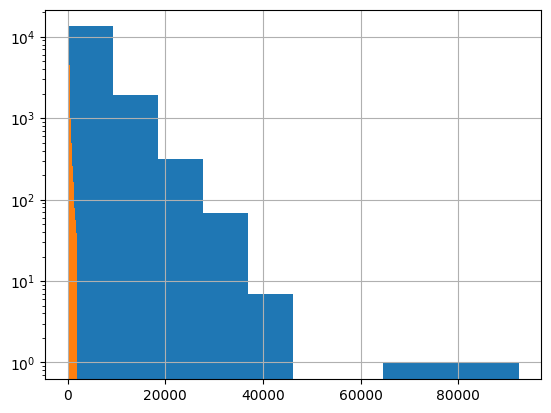

In [13]:
#histograms for outliers
display(df.distance_m.hist())
plt.gca().set_yscale('log')

display(df.wait_sec.hist())
plt.gca().set_yscale('log')

#### Check correlations

C:\Users\ASANGWA\AppData\Local\Temp\ipykernel_21340\570469017.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = df.corr()


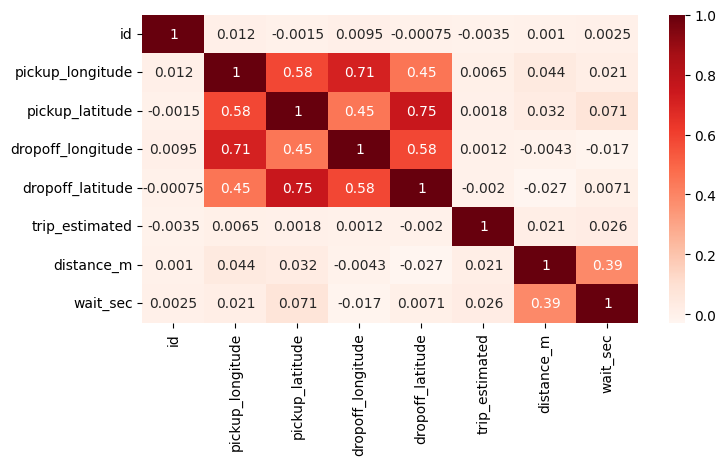

In [14]:
#check correlations using Pearson Correlation
plt.figure(figsize=(8, 4))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()
#note: only the coordinates are highly correlated, which is expected

Use train_test_split from the submodule sklearn.model_selection to split the data into test and training set. Pass the following parameters: random_state = 42, test_size = 0.1 so that you can later compare your predictions with our model and get an initial estimate. Also save features_test as features_test.csv

In [15]:
#read in the dataframe again to remove previous changes
df = pd.read_csv("data_train.csv")

In [16]:
# perform train-test-split
from sklearn.model_selection import train_test_split

target = df.loc[:,'wait_sec']
features = df.drop('wait_sec', axis=1)

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            random_state=42,
                                                                            test_size=0.1)

In [17]:
# save features_test as 'features_test.csv'
features_test.to_csv('features_test.csv', index=False)

### Data Preparation

#### Transforming Data Types

In [18]:
#copy target_train
df = features_train.copy()

In [19]:
#change datetime
df.loc[:, 'pickup_datetime'] = pd.to_datetime(df.loc[:, 'pickup_datetime'])

C:\Users\ASANGWA\AppData\Local\Temp\ipykernel_21340\708875204.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'pickup_datetime'] = pd.to_datetime(df.loc[:, 'pickup_datetime'])


### Data Cleaning

In [20]:
# clean_data function
def clean_data(df):
    """Returns cleaned DataFrame.
    
    Transform datatypes:
        -transform 'pickup_datetime' to datetime format
    
    Args: 
        df (pd.DataFrame) : uncleaned DataFrame
        
    Returns:
        df  (pd.DataFrame) : cleaned DataFrame
    
    """
    #to datetime
    df['pickup_datetime'] = pd.to_datetime(df.loc[:, 'pickup_datetime'])
   
    #no NaNs, so no more steps necessary

    return df

### Dealing with Outliers 

In [21]:
#remove latitude and longitude out of range: [-0.4,0.05][-78.6,-78.3]
df = df[(df['pickup_longitude'] >= -78.6) & (df['pickup_longitude'] <= -78.3)]
df = df[(df['dropoff_longitude'] >= -78.6) & (df['dropoff_longitude'] <= -78.3)]
df = df[(df['pickup_latitude'] >= -0.4) & (df['pickup_latitude'] <= 0.05)]
df = df[(df['dropoff_latitude'] >= -0.4) & (df['dropoff_latitude'] <= 0.05)]

In [22]:
#removing outliers in trip_estimated with RANSAC
#first the median absolute deviation
d_dist = mad(df.loc[:, 'distance_m']) * 3

model_outlier = RANSACRegressor(residual_threshold=d_dist, random_state=0)
model_outlier.fit(X=df.loc[:, ['trip_estimated']],
                  y=df.loc[:, 'distance_m'])

df = df.loc[model_outlier.inlier_mask_, :]

In [43]:
def sampling_data(features, target):
    """Sample Dataframe.
    Only keeping datapoints that are not outliers.

    Keeping only the coordinates in the region of Quito.
    Removing outliers in 'trip_estimated' with RANSAC.
    """

    # Creating mask - update to use bool or np.bool_
    mask = np.ones(len(features), dtype=bool)  # Using Python's built-in bool type
    # Alternatively, you can use np.bool_
    # mask = np.ones(len(features), dtype=np.bool_)
    
    # Remove latitude and longitude out of range: [-0.4,0.05][-78.6,-78.3]
    mask[(features['pickup_longitude'] <= -78.6) | (features['pickup_longitude'] >= -78.3)] = False
    mask[(features['dropoff_longitude'] <= -78.6) | (features['dropoff_longitude'] >= -78.3)] = False
    mask[(features['pickup_latitude'] <= -0.4) | (features['pickup_latitude'] >= 0.05)] = False
    mask[(features['dropoff_latitude'] <= -0.4) | (features['dropoff_latitude'] >= 0.05)] = False

    # Removing outliers in trip_estimated with RANSAC
    # First, the median absolute deviation
    d_dist = mad(features.loc[:, 'distance_m']) * 3

    model_outlier = RANSACRegressor(residual_threshold=d_dist, random_state=0)
    model_outlier.fit(X=features.loc[:, ['trip_estimated']], 
                      y=features.loc[:, 'distance_m'])

    mask[~model_outlier.inlier_mask_] = False
    
    # Applying mask to df
    features = features[mask]
    target = target[features.index]
    
    return features, target


### Modeling

In [24]:
# feature selection
feature_cols = ["trip_estimated",
                "distance_m"]

In [25]:
#simple linear regression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#select features
features_train_copy = features_train.loc[:, feature_cols]
features_test_copy = features_test.loc[:, feature_cols]

linreg2 = Pipeline([
    ("standard_scaler", StandardScaler()),
    ("linear_regression", LinearRegression(n_jobs=-1))
])
linreg2.fit(features_train_copy, target_train)

#predict
linreg2_predictions = linreg2.predict(features_test_copy)

#evaluate
print("simple linear regression\n-------------")
print("R2 :", r2_score(target_test, linreg2_predictions))
print("MAE :", mean_absolute_error(target_test, linreg2_predictions))

simple linear regression
-------------
R2 : 0.18591654367730304
MAE : 180.98526196088372


#### Feature Engineering

In [26]:
#transform vendor_id to binary, call the column 'Quito'
vendor = (df.vendor_id == 'Quito').astype(int)
vendor = vendor.astype(float)
df['Quito'] = vendor
df = df.drop(['vendor_id'], axis=1)

In [27]:
#create new feature speed
df['speed'] = (df.distance_m / 1000) / (df.trip_estimated / 3600)

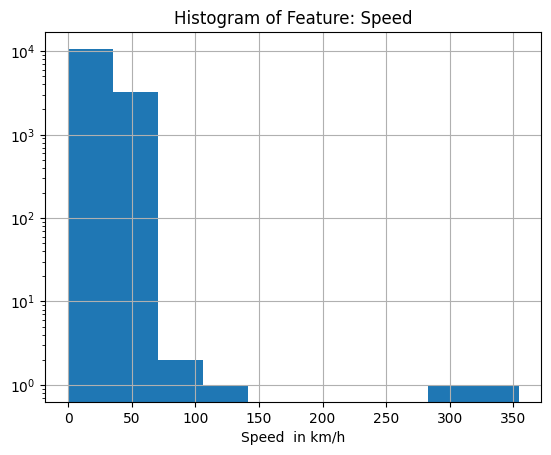

In [28]:
#histogram of speed
df.speed.hist()
plt.title('Histogram of Feature: Speed')
plt.xlabel('Speed  in km/h')
plt.gca().set_yscale('log')

In [29]:
# looks like there are more outliers
# define plausible speed range
min_speed = 4  # walking speed
max_speed = 80 # max allowed speed in quito is 70

df = df[(df['speed']>=min_speed) & (df['speed']<=max_speed)]

# apply selection
features_train = features_train.loc[df.index,:]
target_train = target_train.loc[df.index]

Text(0, 0.5, 'wait_sec in sec')

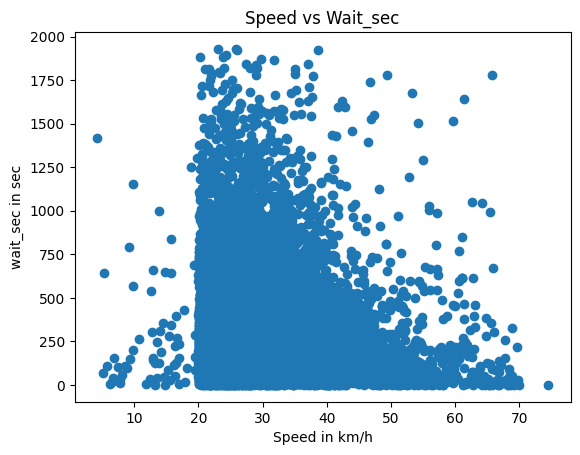

In [30]:
#plot speed against wait_sec
plt.scatter(x=df.loc[:,'speed'],
            y=target_train)
plt.title('Speed vs Wait_sec')
plt.xlabel('Speed in km/h')
plt.ylabel('wait_sec in sec')

In [31]:
# weekend
df['weekend'] = (df['pickup_datetime'].dt.weekday > 4).astype(int)

In [32]:
# season
def get_season(month):
    """Return if month in dry or wet Season
    
    Dry Season : Jun - Sep
    Wet Season : Oct - May
    
    Args:
        month (int): Month from Datetime
    
    Returns:
        bool: 0 for wet season, 1 for dry season.
    """
    if 9>= month >=6:
        return 0
    return 1   

df['season'] = df['pickup_datetime'].dt.month.apply(get_season)

In [33]:
# calculating haversine distance
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    
    Args: 
        lon1 (float) : longitude from start location
        lat1 (float) : latitude from start location
        lon2 (float) : longitude from end location
        lat2 (float) : longitude from end location
    
    Returns:
        float: distance between two points on earth
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [34]:
#distance to center using haversine formula
quito_center = (-0.175, -78.5) #longitude, latitude

df["pickup_distance_to_center"] = (df[['pickup_latitude', 'pickup_longitude']].
                                   apply(lambda x: haversine(x[1], 
                                                             x[0], 
                                                             quito_center[1], 
                                                             quito_center[0]), 
                                         axis=1))

df["dropoff_distance_to_center"] = (df[['dropoff_latitude','dropoff_longitude']]
                                      .apply(lambda x: haversine(x[1], 
                                                                 x[0], 
                                                                 quito_center[1], 
                                                                 quito_center[0]),
                                             axis=1))

Text(0.5, 0, 'distance_to_center in km')

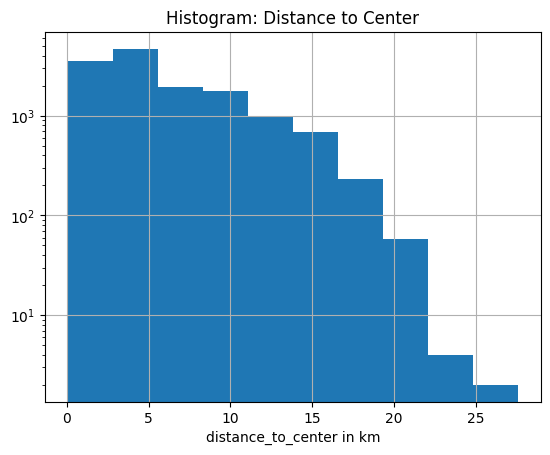

In [35]:
# show histogram of distance to center
df.pickup_distance_to_center.hist()
plt.gca().set_yscale('log')
plt.title('Histogram: Distance to Center')
plt.xlabel('distance_to_center in km')

In [36]:
#going downtown or uptown
df["to_center"] = (df["pickup_distance_to_center"] > df["dropoff_distance_to_center"])

In [37]:
# define engineer_features function

from math import radians, cos, sin, asin, sqrt

def engineer_features(df):
    """Add new Features to Dataframe.
    
    Add 'Quito', 'speed' , 'weekend' , 'season' , pickup_distance_to_center , 
    'dropoff_distance_to_center' , 'to_center', 
    Convert categorical features to one hot representation/ binary
    
    Args:
        df (pd.DataFrame): Dataframe
    
    Returns:
        (pd.DataFrame) : Dataframe with new Features
    """  
    
    #transform vendor_id to binary, call the column 'Quito'
    vendor = (df.vendor_id == 'Quito').astype(int)
    vendor = vendor.astype(float)
    df['Quito'] = vendor
    df = df.drop(['vendor_id'], axis=1)
    
    #drop unnecessary columns
    df = df.drop(['store_and_fwd_flag', 'id'], axis = 1)

    #create new feature speed
    df['speed'] = (df.distance_m / 1000) / (df.trip_estimated / 3600)
    
    #define plausible speed range
    #min_speed = 4  # walking speed
    #max_speed = 80 # max allowed speed in quito is 70

    #df = df[(df['speed']>=min_speed) & (df['speed']<=max_speed)]

    # weekend
    df['weekend'] = (df['pickup_datetime'].dt.weekday > 4).astype(int)
    
    # season
    df['season'] = df['pickup_datetime'].dt.month.apply(get_season)
    
    #distance to center using haversine formula
    quito_center = (-0.175, -78.5) #longitude, latitude

    df["pickup_distance_to_center"] = (df[['pickup_latitude', 'pickup_longitude']].
                                   apply(lambda x: haversine(x[1], 
                                                             x[0], 
                                                             quito_center[1], 
                                                             quito_center[0]), 
                                         axis=1))

    df["dropoff_distance_to_center"] = (df[['dropoff_latitude','dropoff_longitude']]
                                      .apply(lambda x: haversine(x[1], 
                                                                 x[0], 
                                                                 quito_center[1], 
                                                                 quito_center[0]),
                                             axis=1))
    
    #going downtown or uptown
    df["to_center"] = (df["pickup_distance_to_center"] > df["dropoff_distance_to_center"]).astype(int)

    return df

#put custom functions needed for data_engineering here

def get_season(month):
    """Return if month in dry or wet Season
    
    Dry Season : Jun - Sep
    Wet Season : Oct - May
    
    Args:
        month (int): Month from Datetime
    
    Returns:
        str: 0 or 4 according to inputted month.
    """
    if 9>= month >=6:
        return 0
    return 1

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [38]:
#sampling_feature_df function
def sampling_feature_df(features, target):
    """Deals with outliers in new Features,
     after feature engineering step.

     Removing Speed out of range.

     Args:
        features (pd.DataFrame): DataFrame containing outliers
        target (pd.Series) : Series with target values matching to features
    
    Returns:
        (pd.DataFrame) : Filtered features
        (pd.Series) : Filtered target
    """
    #define plausible speed range
    min_speed = 4  # walking speed
    max_speed = 80 # max allowed speed in quito is 70

    features = features[(features['speed']>=min_speed) & (features['speed']<=max_speed)]
    target = target[features.index]
        
    return features, target

### Feature Selection

In [39]:
# feature selection
feature_cols = ['trip_estimated', 
                'distance_m', 
                'speed', 
                'weekend', 
                'season',
                'pickup_distance_to_center',
                'to_center']

### Modeling

In [40]:
# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RANSACRegressor

# Preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Validation
from sklearn.model_selection import KFold, cross_val_score, validation_curve, GridSearchCV

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.svm import SVC
from statsmodels.robust import mad

In [45]:
# apply clean_data, sampling_data, engineer_features and sampling_feature_df
features_train = clean_data(features_train)
# Correct the mask creation line
# or use dtype=np.bool_
#mask = np.ones(len(features), np.bool)
features_train, target_train = sampling_data(features_train, target_train)
features_train = engineer_features(features_train)
features_train, target_train = sampling_feature_df(features_train, target_train)

features_test = clean_data(features_test)
features_test = engineer_features(features_test)

C:\Users\ASANGWA\AppData\Local\Temp\ipykernel_21340\582778740.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Quito'] = vendor


In [46]:
#select features
features_train = features_train.loc[:, feature_cols]
features_test = features_test.loc[:, feature_cols]

In [47]:
#linreg
#train
linreg2 = Pipeline([
    ("standard_scaler", StandardScaler()),
    ("linear_regression", LinearRegression(n_jobs=-1))
])
linreg2.fit(features_train, target_train)

#predict
linreg2_predictions = linreg2.predict(features_test)

#evaluate
print("simple linear regression\n-------------")
print("R2 :", r2_score(target_test, linreg2_predictions))
print("MAE :", mean_absolute_error(target_test, linreg2_predictions))

#save model
import pickle
pickle.dump(linreg2, open('linreg2.p', 'wb'))

simple linear regression
-------------
R2 : 0.07675501359681691
MAE : 164.59528040234363


In [48]:
#SVM
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
#train
svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm' , SVR(C=1.0, epsilon=0.2))
    ])
svm.fit(features_train, target_train)

#predict
y_pred = svm.predict(features_test)

#evaluate
print("SVM (regression)\n-------------")
print("R2 :", r2_score(target_test, y_pred))
print("MAE :", mean_absolute_error(target_test, y_pred))

SVM (regression)
-------------
R2 : 0.2230019414198956
MAE : 155.13711451313452


In [49]:
#Ridge
#train
std_scaler = StandardScaler()
ridge_pipe = Pipeline([('scale', std_scaler),
                       ('model', Ridge(random_state=42, 
                                       alpha=10))])
param_grid = {'model__alpha': [0.0, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
ridge_gs = GridSearchCV(estimator=ridge_pipe,
                        param_grid=param_grid, 
                        scoring="neg_mean_absolute_error",
                        n_jobs=-1, 
                        cv=5, 
                        verbose=4)

ridge_gs.fit(features_train, target_train)
          
#predict
y_pred = ridge_gs.predict(features_test)

#evaluate
print("Ridge\n-------------")
print("R2 :", r2_score(target_test, y_pred))
print("MAE :", mean_absolute_error(target_test, y_pred))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Ridge
-------------
R2 : 0.07675501359681425
MAE : 164.59528040234352


In [50]:
#ANN
from tensorflow.keras.layers import Lambda, Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler

model_ann = Sequential()
model_ann.add(Input(7))
model_ann.add(Dense(units=12, activation='relu'))
model_ann.add(Dropout(rate=0.2))
model_ann.add(Dense(units=8, activation='relu'))
model_ann.add(Dropout(rate=0.2))
model_ann.add(Dense(units=1))

model_ann.compile(optimizer='adam', loss='mae', metrics=['mse', 'mae'])

#train
model_hist = model_ann.fit(features_train, target_train, epochs=30, batch_size=64, validation_split=0.2)

#predict
y_pred = model_ann.predict(features_test)

#evaluate
print("ANN\n-------------")
print("R2 :", r2_score(target_test, y_pred))
print("MAE :", mean_absolute_error(target_test, y_pred))




Epoch 1/30


174/174 [==============================] - 1s 3ms/step - loss: 286.8561 - mse: 194710.3281 - mae: 286.8561 - val_loss: 190.4740 - val_mse: 84300.9297 - val_mae: 190.4740
Epoch 2/30
174/174 [==============================] - 0s 2ms/step - loss: 210.4843 - mse: 100872.2578 - mae: 210.4843 - val_loss: 179.8680 - val_mse: 76528.2734 - val_mae: 179.8680
Epoch 3/30
174/174 [==============================] - 0s 2ms/step - loss: 197.9513 - mse: 92857.9297 - mae: 197.9513 - val_loss: 178.6188 - val_mse: 75724.9219 - val_mae: 178.6188
Epoch 4/30
174/174 [==============================] - 0s 2ms/step - loss: 194.1107 - mse: 89121.3984 - mae: 194.1107 - val_loss: 175.8124 - val_mse: 73764.8125 - val_mae: 175.8124
Epoch 5/30
174/174 [==============================] - 0s 2ms/step - loss: 191.6434 - mse: 86608.0312 - mae: 191.6434 - val_loss: 178.4464 - val_mse: 76593.5156 - val_mae: 178.4464
Epoch 6/30
174/174 [==============================] - 0s 2ms/step - loss: 186.0025 - mse: 826

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


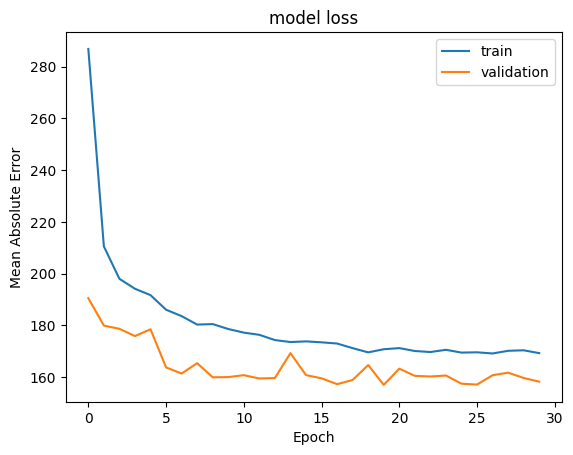

In [51]:
#visualize loss
import matplotlib.pyplot as plt
print(model_hist.history.keys())
# "Loss"
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Model Selection

In [52]:
#save best model
pickle.dump(svm, open('best_model.p', 'wb'))

## The final data pipeline

In [53]:
# define master function
def predict_wait_sec_reference(csv_file, model):
    """Estimate waiting time in seconds for taxi-rides in the Quito area.
    
    Args:
        csv_file (str): Path of the incoming data csv file holding the following columns;
           '', 'id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
           'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
           'dropoff_latitude', 'store_and_fwd_flag', 'trip_estimated', 'distance_m'
        model (model): The trained model
    
    Returns:
        numpyArray: Estimated waiting time [seconds]
    """
    #read
    features = pd.read_csv(csv_file, parse_dates=['pickup_datetime'])
    #clean
    features = clean_data(features)
    #features
    features = engineer_features(features)
     # feature selection
    feature_cols = ['trip_estimated',
                    'distance_m', 
                    'speed', 
                    'weekend',
                    'season',
                    'pickup_distance_to_center', 
                    'to_center']
    #select features
    features = features.loc[:, feature_cols]
    #predict
    predictions = model.predict(features)
    return predictions

In [54]:
### reference: ###
#model = LinearRegression(n_jobs=-1)
#train
#model.fit(features_train, target_train)

model = pickle.load(open('linreg2.p', 'rb'))

#predict
y_pred = predict_wait_sec_reference('features_test.csv', model)

#evaluate:
#make predictions on features_test.csv
print("Referenzmodell\n-------------")
print('r2-Test:', r2_score(target_test, y_pred))
print('MAE-Test:', mean_absolute_error(target_test, y_pred))

Referenzmodell
-------------
r2-Test: 0.07675501359681691
MAE-Test: 164.59528040234363


### Completing the project

In [55]:
# make predictions on features_aim.csv
model = pickle.load(open('best_model.p', 'rb'))

#predict
y_pred = predict_wait_sec_reference('features_aim.csv', model)
target_aim = pd.read_csv('target_aim.csv')

#evaluate:
#make predictions on features_test.csv
print("Referenzmodell\n-------------")
print('r2-Test:', r2_score(target_aim, y_pred))
print('MAE-Test:', mean_absolute_error(target_aim, y_pred))

Referenzmodell
-------------
r2-Test: 0.20245029367999556
MAE-Test: 153.7443029176469


In [56]:
#save predictions as predictions_aim.csv
pd.Series(y_pred).to_csv('y_pred.csv', index=False)